# Postprocessing and plots

The outputlib module
https://oemof.readthedocs.io/en/stable/api/oemof.outputlib.html

## Imports pandas, matplotlib and oemof

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import oemof.solph as solph
import oemof.outputlib as outputlib
from oemof.tools.economics import annuity

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = [20.0, 7.0]
rcParams['font.size'] = 25

## Restore the energysystem with results

In [3]:
energysystem = solph.EnergySystem()
energysystem.restore(dpath=None, filename=None)

'Attributes restored from: /home/jann/.oemof/dumps/es_dump.oemof'

## Filter the dictionary using outputlib
### Get all the flows into and out of the electricity bus


In [4]:
results_bus_el = outputlib.views.node(energysystem.results['main'], 'electricity')['sequences']
# results_bus_th = outputlib.views.node(energysystem.results['main'], 'heat')['sequences']
results_bus_el.columns = [col[0] for col in results_bus_el.columns]
results_bus_el.index.name = 'timeindex'
results_bus_el

,"(chp_gas, electricity)","(electricity, demand_el)","(electricity, excess_el)","(electricity, storage_el)","(pp_coal, electricity)","(pv, electricity)","(shortage_el, electricity)","(storage_el, electricity)","(wind, electricity)"
timeindex,,,,,,,,,
2016-01-01 00:00:00,4.408357,52.169653,0.0,0.000000,29.329896,0.000000,0.0,0.0,18.43140
2016-01-01 01:00:00,4.501334,52.169653,0.0,0.000000,29.038019,0.000000,0.0,0.0,18.63030
2016-01-01 02:00:00,4.707776,47.392644,0.0,0.000000,23.921967,0.000000,0.0,0.0,18.76290
2016-01-01 03:00:00,5.221512,45.197772,0.0,0.000000,21.213360,0.000000,0.0,0.0,18.76290
2016-01-01 04:00:00,23.333685,44.189789,0.0,0.000000,4.148504,0.000000,0.0,0.0,16.70760
2016-01-01 05:00:00,30.000000,42.397456,0.0,0.000000,0.065656,0.000000,0.0,0.0,12.33180
2016-01-01 06:00:00,26.740622,39.072422,0.0,0.000000,0.000000,0.000000,0.0,0.0,12.33180
2016-01-01 07:00:00,26.521109,38.786609,0.0,0.000000,0.000000,0.000000,0.0,0.0,12.26550
2016-01-01 08:00:00,26.699229,39.558959,0.0,0.000000,0.000000,0.594230,0.0,0.0,12.26550


### Prepare input parameters for postprocessing

In [5]:
params = energysystem.params
params

{("<oemof.solph.network.Bus: 'coal'>",
  "<oemof.solph.network.Transformer: 'pp_coal'>"): {'scalars': fixed                                                                  False
  label                      EdgeLabel(input="<oemof.solph.network.Bus: 'co...
  max                                                                        1
  min                                                                        0
  negative_gradient_costs                                                    0
  positive_gradient_costs                                                    0
  variable_costs                                                             0
  dtype: object, 'sequences': Empty DataFrame
  Columns: []
  Index: []},
 ("<oemof.solph.network.Bus: 'gas'>",
  "<oemof.solph.network.Transformer: 'chp_gas'>"): {'scalars': fixed                                                                  False
  label                      EdgeLabel(input="<oemof.solph.network.Bus: 'ga...
  max           

In [6]:
def convert_params_to_dataframe(params):
    r"""
    
    """    
    param_df = pd.DataFrame()
    for key in params.keys():
        new_row = params[key]['scalars']
        label = tuple(map(str, key)) if isinstance(key, tuple) else str(key)
        new_row['label'] = label
        new_row['from'] = label[0]
        new_row['to'] = label[1]
        param_df = param_df.append(new_row, ignore_index=True)
        
    param_df['fixed'] = param_df['fixed'].astype('bool')
    param_df = param_df[param_df.columns.drop('label').insert(0, 'label')]
    param_df = param_df.set_index('label')
    return param_df

params_df = convert_params_to_dataframe(params)
params_df.head()

,fixed,from,max,min,negative_gradient_costs,positive_gradient_costs,to,variable_costs,nominal_value,emission_factor,...,conversion_factors_electricity,conversion_factors_gas,conversion_factors_heat,inflow_conversion_factor,initial_storage_level,loss_rate,max_storage_level,min_storage_level,nominal_storage_capacity,outflow_conversion_factor
label,,,,,,,,,,,,,,,,,,,,,
"(coal, pp_coal)",False,coal,1.0,0.0,0.0,0.0,pp_coal,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(gas, chp_gas)",False,gas,1.0,0.0,0.0,0.0,chp_gas,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(electricity, demand_el)",True,electricity,1.0,0.0,0.0,0.0,demand_el,0.0,85.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(electricity, storage_el)",False,electricity,1.0,0.0,0.0,0.0,storage_el,0.0,200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(electricity, excess_el)",False,electricity,1.0,0.0,0.0,0.0,excess_el,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define color dictionary

Use color palette generators to generate suitable colors, e.g.:     
http://javier.xyz/cohesive-colors/  
https://colourco.de/  
http://seaborn.pydata.org/tutorial/color_palettes.html  

In [7]:
cdict = {('chp_gas', 'electricity'): '#eeac7e',
        ('pp_coal', 'electricity'): '#0f2e2e',
        ('pv', 'electricity'): '#ffde32',
        ('wind', 'electricity'): '#4ca7c3',
        ('electricity', 'demand_el'): '#000000',
        ('electricity', 'storage_el'): '#E04644',
        ('storage_el', 'electricity'): '#B7D968',
        ('electricity', 'excess_el'): '#C748E2',
        ('shortage_el', 'electricity'): '#B576AD'}

## Plot renewable feedin and demand

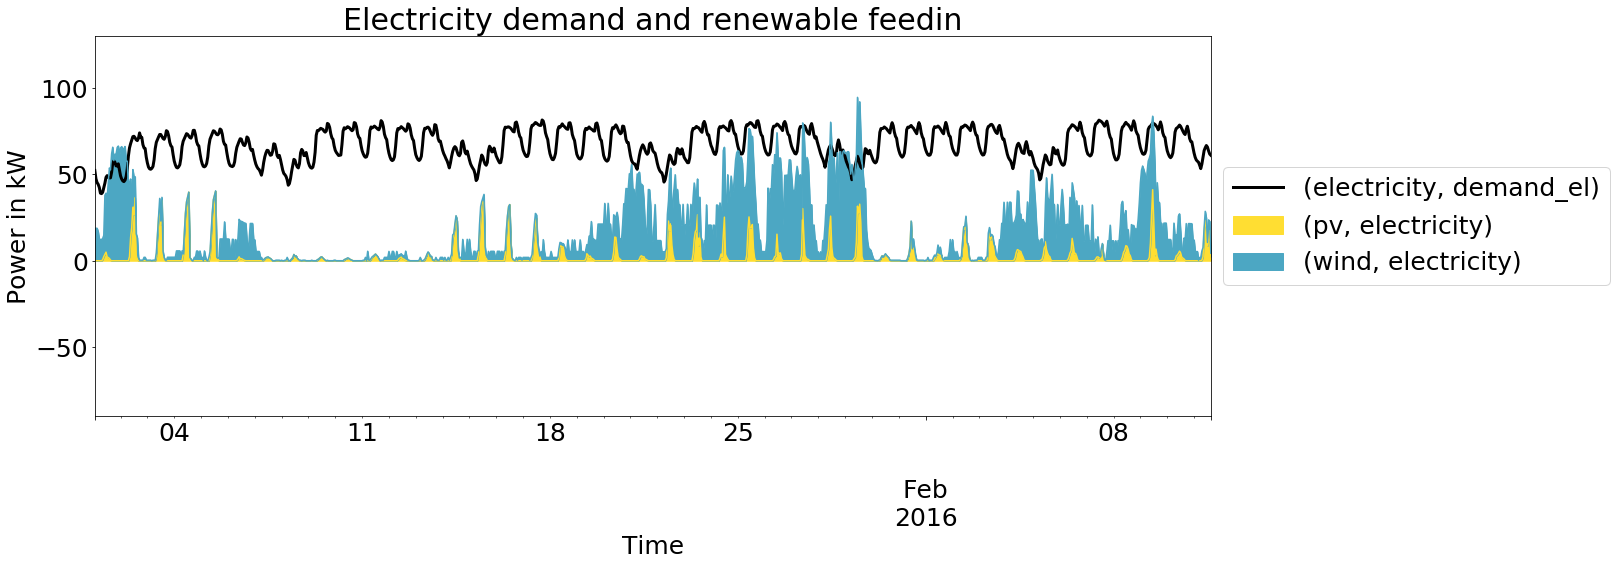

In [8]:
seq_re = results_bus_el[[('pv', 'electricity'), ('wind', 'electricity')]]
seq_demand = results_bus_el[('electricity', 'demand_el')]

range_low = 1
range_high = 1000

fig, ax = plt.subplots()
color = [cdict[column] for column in seq_re.columns]
seq_demand[range_low:range_high].plot(ax=ax, linewidth=3, color='k')
seq_re[range_low:range_high].plot.area(ax=ax, color=color)
ax.set_ylim(-90, 130)
ax.set_ylabel('Power in kW')
ax.set_xlabel('Time')
ax.set_title('Electricity demand and renewable feedin')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # place legend outside of plot
plt.show()

## Plot all dispatch

In [56]:
produced_el = results_bus_el.drop(('electricity', 'demand_el'), axis=1)
produced_el = produced_el.clip(lower=0)
produced_el[('electricity', 'storage_el')] *= -1

In [81]:
sorted_columns = [('electricity', 'storage_el'),
                  ('storage_el', 'electricity'),
                  ('wind', 'electricity'),
                  ('pv', 'electricity'),
                  ('pp_coal', 'electricity'),
                  ('chp_gas', 'electricity'),
                  ('electricity', 'excess_el'),
                  ('shortage_el', 'electricity')]

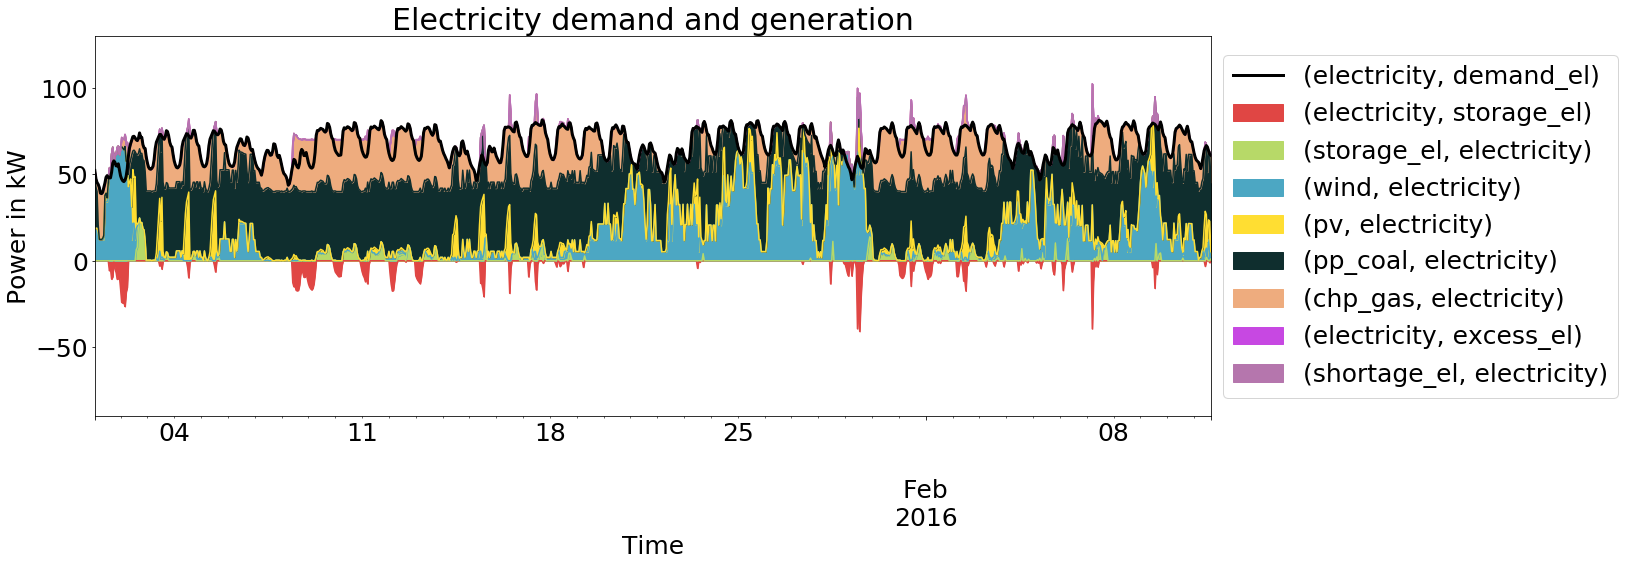

In [82]:
fig, ax = plt.subplots()
color = [cdict[column] for column in produced_el.columns]
produced_el[range_low:range_high].plot.area(ax=ax, color=color)
seq_demand[range_low:range_high].plot(c='k', linewidth=3)
ax.set_ylim(-90, 130)
ax.set_ylabel('Power in kW')
ax.set_xlabel('Time')
ax.set_title('Electricity demand and generation')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # place legend outside of plot
plt.show()

### Plot Jahresdauerlinie

In [11]:
sorted_sequences = pd.DataFrame()
for column in results_bus_el.columns:
    sorted_sequences[column]=sorted(results_bus_el[column], reverse=True)

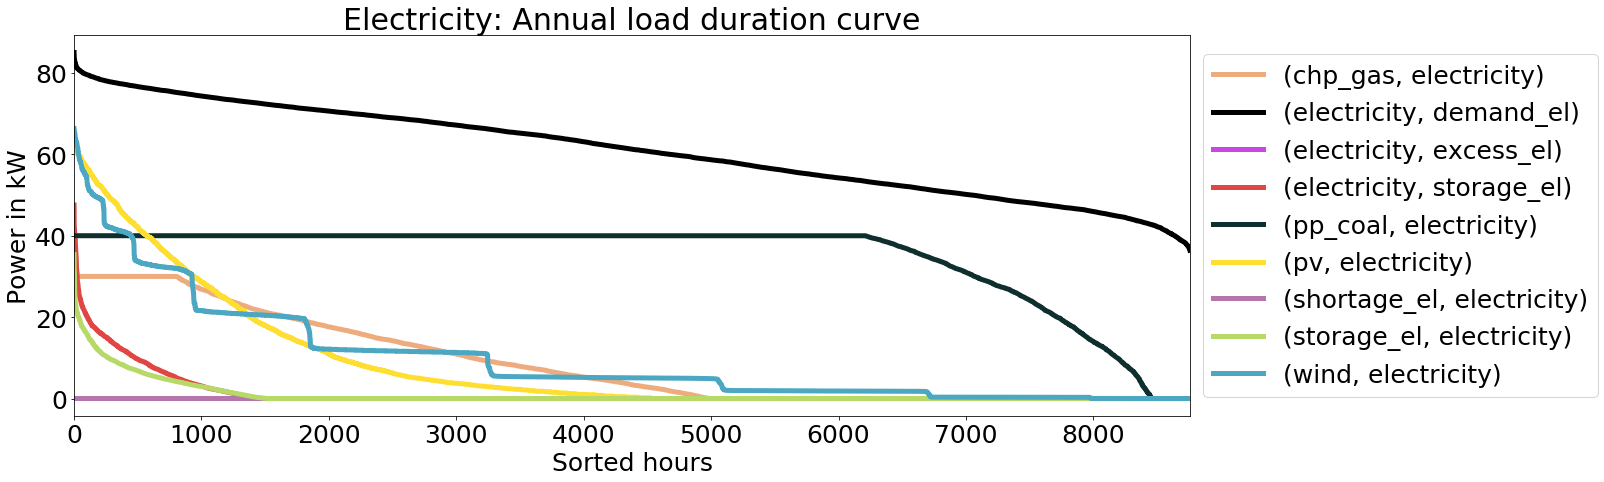

In [12]:
fig, ax = plt.subplots()
color = [cdict[column] for column in sorted_sequences.columns]
sorted_sequences.plot(ax=ax, color=color, linewidth=5)
ax.set_ylabel('Power in kW')
ax.set_xlabel('Sorted hours')
ax.set_title('Electricity: Annual load duration curve')
legend = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # place legend outside of plot
plt.show()

## Calculate metrics and indicators

### Installierte Leistung für Technologie i
$$P_{inst,i}$$

In [13]:
to_bus_el = [i[1]=='electricity' for i in params_df.index]
params_df_to_el = params_df.loc[to_bus_el]
params_df_to_el

,fixed,from,max,min,negative_gradient_costs,positive_gradient_costs,to,variable_costs,nominal_value,emission_factor,...,conversion_factors_electricity,conversion_factors_gas,conversion_factors_heat,inflow_conversion_factor,initial_storage_level,loss_rate,max_storage_level,min_storage_level,nominal_storage_capacity,outflow_conversion_factor
label,,,,,,,,,,,,,,,,,,,,,
"(wind, electricity)",True,wind,1.0,0.0,0.0,0.0,electricity,0.0,66.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(pv, electricity)",True,pv,1.0,0.0,0.0,0.0,electricity,0.0,65.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(pp_coal, electricity)",False,pp_coal,1.0,0.0,0.0,0.0,electricity,0.0,40.0,0.335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(chp_gas, electricity)",False,chp_gas,1.0,0.0,0.0,0.0,electricity,0.0,30.0,0.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(storage_el, electricity)",False,storage_el,1.0,0.0,0.0,0.0,electricity,0.0,200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(shortage_el, electricity)",False,shortage_el,1.0,0.0,0.0,0.0,electricity,100000.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
p_inst = params_df_to_el['nominal_value'].loc[params_df_to_el['nominal_value']>0]
p_inst = p_inst.sort_index()
p_inst = p_inst.rename('installed_capacity')
p_inst

label
(chp_gas, electricity)        30.0
(pp_coal, electricity)        40.0
(pv, electricity)             65.3
(storage_el, electricity)    200.0
(wind, electricity)           66.3
Name: installed_capacity, dtype: float64

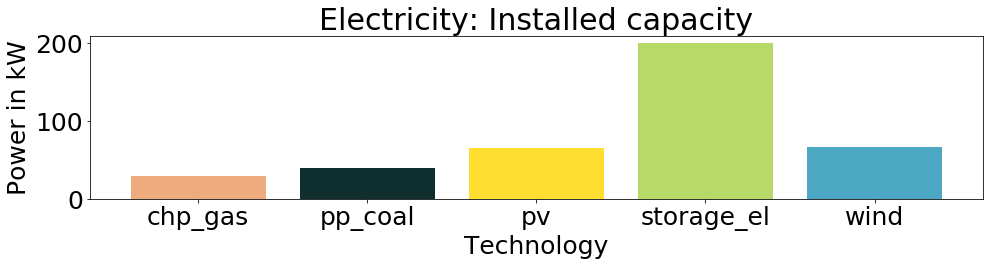

In [15]:
fig, ax = plt.subplots(figsize=(16,3))
color = [cdict[label] for label in p_inst.index]
x = [label[0] for label in p_inst.index]
height = p_inst.values
plt.bar(x=x, height=height, color=color)
ax.set_ylabel('Power in kW')
ax.set_xlabel('Technology')
ax.set_title('Electricity: Installed capacity')
plt.show()

### Jährliche Energiemenge für Technologie i
$$E_{ges,i} = \sum_t P_{t,i} \cdot \Delta t$$

In [16]:
to_bus_el = [column for column in results_bus_el.columns if column[1]=='electricity']
yearly_energy = results_bus_el[to_bus_el].sum()
yearly_energy = yearly_energy.sort_index()
yearly_energy = yearly_energy.rename('yearly_energy')
yearly_energy

(chp_gas, electricity)         76208.437442
(pp_coal, electricity)        303989.256012
(pv, electricity)              70874.122713
(shortage_el, electricity)         0.000000
(storage_el, electricity)       8983.264764
(wind, electricity)            85427.968459
Name: yearly_energy, dtype: float64

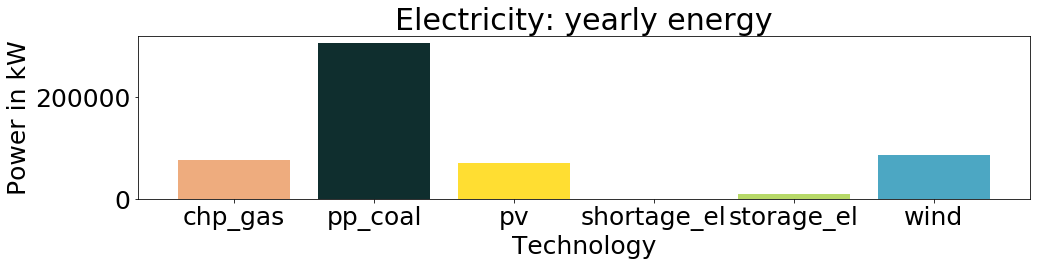

In [17]:
fig, ax = plt.subplots(figsize=(16,3))
x = [label[0] for label in yearly_energy.index]
height = yearly_energy.values
color = [cdict[label] for label in yearly_energy.index]
plt.bar(x=x, height=height, color=color)
ax.set_ylabel('Power in kW')
ax.set_xlabel('Technology')
ax.set_title('Electricity: yearly energy')
plt.show()

### Volllaststunden von Technologie i
$$t_{Volllast, i} = \frac{E_{ges,i}}{P_{inst,i}}$$

In [18]:
full_load_hours =  yearly_energy * 1/p_inst
full_load_hours = full_load_hours.rename('full_load_hours')
full_load_hours

(chp_gas, electricity)        2540.281248
(pp_coal, electricity)        7599.731400
(pv, electricity)             1085.361757
(shortage_el, electricity)            NaN
(storage_el, electricity)       44.916324
(wind, electricity)           1288.506312
Name: full_load_hours, dtype: float64

### Deckungsgrad von Technologie i
$$\frac{E_{ges,i}}{\sum_i E_{ges,i}}, \ for \ i \ \neq \ storage $$

In [19]:
yearly_production = yearly_energy.drop(('storage_el', 'electricity'))
coverage_ratio = (yearly_production * 1/(yearly_production.sum()))
coverage_ratio = coverage_ratio.rename('coverage_ratio')
coverage_ratio

(chp_gas, electricity)        0.142047
(pp_coal, electricity)        0.566616
(pv, electricity)             0.132105
(shortage_el, electricity)    0.000000
(wind, electricity)           0.159232
Name: coverage_ratio, dtype: float64

### Speicherzyklen
https://github.com/oemof/cydets

In [20]:
from cydets.algorithm import detect_cycles

charge_el = results_bus_el[('electricity', 'storage_el')]
cycles = detect_cycles(charge_el)
cycles.head()

,t_start,t_end,t_minimum,doc,duration
0,2016-01-01 14:00:00,2016-01-01 16:00:00,2016-01-01 15:00:00,0.024210,0 days 02:00:00
1,2016-01-01 16:00:00,2016-01-01 21:00:00,2016-01-01 18:00:00,0.221220,0 days 05:00:00
2,2016-01-01 21:00:00,2016-01-02 02:00:00,2016-01-01 23:00:00,0.035532,0 days 05:00:00
3,2016-01-02 02:00:00,2016-01-02 04:00:00,2016-01-02 03:00:00,0.000357,0 days 02:00:00
4,2016-01-02 04:00:00,2016-01-29 11:00:00,2016-01-02 07:00:00,0.556630,27 days 07:00:00


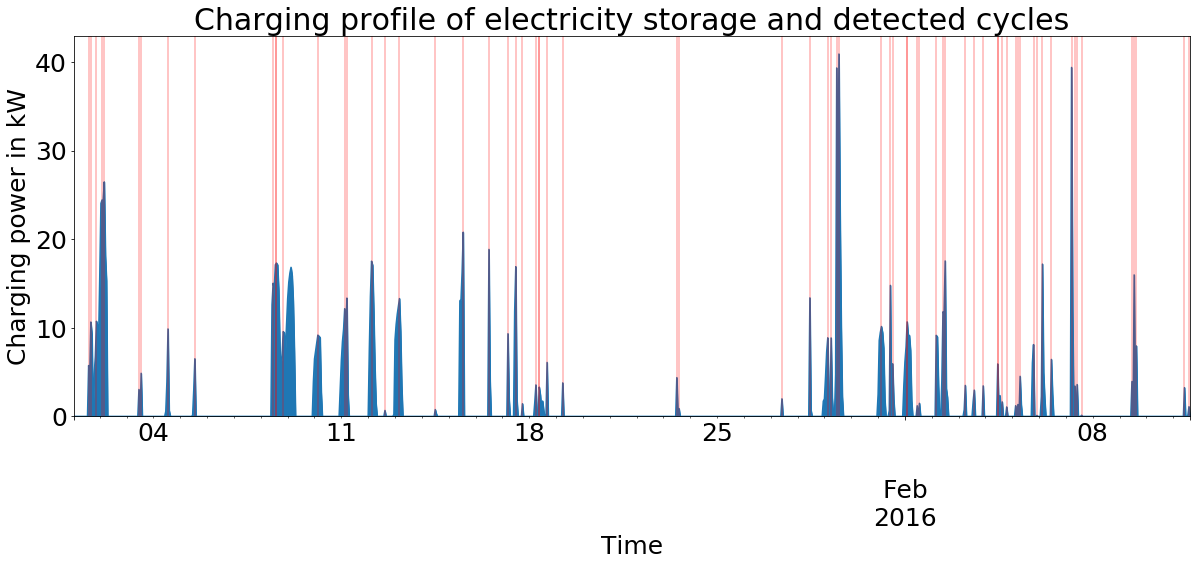

In [21]:
range_low = 1
range_high = 1000

fig, ax = plt.subplots()
charge_el[range_low:range_high].plot.area(ax=ax)
for timepoint in cycles['t_start']:
    ax.axvline(x=timepoint, c='r', alpha=0.3)
ax.set_ylabel('Charging power in kW')
ax.set_xlabel('Time')
ax.set_title('Charging profile of electricity storage and detected cycles')
plt.show()

### Gesamte Treibhausgasemissionen

Zur Verteilung von Emissionen auf Strom und Wärme siehe diesen Vergleich verschiedener Allokationsmethoden:

https://www.ffe.de/download/wissen/334_Allokationsmethoden_CO2/ET_Allokationsmethoden_CO2.pdf


In [22]:
emission_factors = params_df['emission_factor'].loc[params_df['emission_factor']>0]
emission_factors

label
(pp_coal, electricity)    0.335
(chp_gas, electricity)    0.202
Name: emission_factor, dtype: float64

In [23]:
string_results = outputlib.processing.convert_keys_to_strings(energysystem.results['main'])
flows_with_emissions = pd.concat([string_results[i]['sequences']['flow'].rename(i)  for i in emission_factors.index], axis=1)
flows_with_emissions.sum()

pp_coal  electricity    303989.256012
chp_gas  electricity     76208.437442
dtype: float64

In [24]:
emissions = emission_factors * flows_with_emissions.sum()
emissions = emissions.rename('emissions')
emissions

label
(pp_coal, electricity)    101836.400764
(chp_gas, electricity)     15394.104363
Name: emissions, dtype: float64

### Gesamtkosten Betrieb
$$\sum_{i} (C_{FOM,i} + \sum_t P_{t, i} C_{VOM})$$

In [25]:
variable_costs = params_df['variable_costs'][params_df['variable_costs']>0]
variable_costs

label
(source_gas, gas)                 30.0
(source_coal, coal)               30.0
(shortage_el, electricity)    100000.0
Name: variable_costs, dtype: float64

In [26]:
flows_with_variable_costs = pd.concat([string_results[i]['sequences']['flow'].rename(i)  for i in variable_costs.index], axis=1)
summed_variable_costs = variable_costs * flows_with_variable_costs.sum()
summed_variable_costs = summed_variable_costs.rename('summed_variable_costs') 
summed_variable_costs

label
(source_gas, gas)             7.620844e+06
(source_coal, coal)           2.338379e+07
(shortage_el, electricity)    0.000000e+00
Name: summed_variable_costs, dtype: float64

### Gesamtkosten Investition
$$\sum_{i} C_{capital,i} P_{inst,i}$$

In [27]:
overnight_costs = pd.Series({('chp_gas', 'electricity'): 2,
                   ('pp_coal', 'electricity'): 2,
                   ('pv', 'electricity'): 2,
                   ('storage_el', 'electricity'): 2,
                   ('wind', 'electricity'): 2}).rename('overnight_cost')

investment_periods = pd.Series({('chp_gas', 'electricity'): 2,
                      ('pp_coal', 'electricity'): 2,
                      ('pv', 'electricity'): 2,
                      ('storage_el', 'electricity'): 2,
                      ('wind', 'electricity'): 2}).rename('investment_period')

wacc = 0.05
def get_annuity(df):
    return annuity(df['overnight_cost'], df['investment_period'], df['wacc'])

annuity_calculation = pd.concat([overnight_costs, investment_periods], axis=1)
annuity_calculation['wacc'] = wacc
annuity_calculation['annuity'] = annuity_calculation.apply(get_annuity, axis=1)
annuity_calculation

,,overnight_cost,investment_period,wacc,annuity
chp_gas,electricity,2,2,0.05,1.07561
pp_coal,electricity,2,2,0.05,1.07561
pv,electricity,2,2,0.05,1.07561
storage_el,electricity,2,2,0.05,1.07561
wind,electricity,2,2,0.05,1.07561


In [28]:
capital_costs = annuity_calculation['annuity'] * p_inst
capital_costs = capital_costs.rename('capital_costs')
capital_costs

chp_gas     electricity     32.268293
pp_coal     electricity     43.024390
pv          electricity     70.237317
storage_el  electricity    215.121951
wind        electricity     71.312927
Name: capital_costs, dtype: float64

## Gesamtübersicht

In [29]:
pd.concat([p_inst,
           yearly_energy,
           full_load_hours,
           coverage_ratio,
           emissions,
           summed_variable_costs,
           capital_costs],
          sort=True,
          axis=1)

,installed_capacity,yearly_energy,full_load_hours,coverage_ratio,emissions,summed_variable_costs,capital_costs
"(chp_gas, electricity)",30.0,76208.437442,2540.281248,0.142047,15394.104363,NaN,32.268293
"(pp_coal, electricity)",40.0,303989.256012,7599.731400,0.566616,101836.400764,NaN,43.024390
"(pv, electricity)",65.3,70874.122713,1085.361757,0.132105,NaN,NaN,70.237317
"(shortage_el, electricity)",NaN,0.000000,NaN,0.000000,NaN,0.000000e+00,NaN
"(source_coal, coal)",NaN,NaN,NaN,NaN,NaN,2.338379e+07,NaN
"(source_gas, gas)",NaN,NaN,NaN,NaN,NaN,7.620844e+06,NaN
"(storage_el, electricity)",200.0,8983.264764,44.916324,NaN,NaN,NaN,215.121951
"(wind, electricity)",66.3,85427.968459,1288.506312,0.159232,NaN,NaN,71.312927
